<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_Treasury10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 879.00 KiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 18:16:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Treasury10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 8.6 MB/s 
     |████████████████████████████████| 138 kB 50.5 MB/s 
     |████████████████████████████████| 170 kB 54.1 MB/s 
     |████████████████████████████████| 133 kB 50.3 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 62 kB 874 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: p36nisax
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/p36nisax


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: zk8oew09 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
16/16 [==============================] - 41s 101ms/step - loss: 0.1292 - mean_squared_error: 0.1292 - mean_absolute_error: 0.2815 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1965
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.1013 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1021
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0659 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0992
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0570 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0921
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0047 - mean_squared

epoch,58
loss,0.00165
mean_squared_error,0.00165
mean_absolute_error,0.03146
val_loss,0.00456
val_mean_squared_error,0.00456
val_mean_absolute_error,0.05363
_runtime,60
_timestamp,1626891456
_step,58
best_val_loss,0.00408


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j23azr2k with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 4s 39ms/step - loss: 0.0996 - mean_squared_error: 0.0996 - mean_absolute_error: 0.2449 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1172
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0717 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1044
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0591 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1030
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0600 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1022
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_squared_erro

epoch,199
loss,0.00184
mean_squared_error,0.00184
mean_absolute_error,0.03361
val_loss,0.00453
val_mean_squared_error,0.00453
val_mean_absolute_error,0.0537
_runtime,69
_timestamp,1626891533
_step,199
best_val_loss,0.00448


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zxop26ze with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 76ms/step - loss: 0.0811 - mean_squared_error: 0.0811 - mean_absolute_error: 0.1827 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1035
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0715 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0903
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0841 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0759
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0527 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0711
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0036 - mean_squared_

epoch,35
loss,0.00207
mean_squared_error,0.00207
mean_absolute_error,0.03496
val_loss,0.00605
val_mean_squared_error,0.00605
val_mean_absolute_error,0.06142
_runtime,16
_timestamp,1626891558
_step,35
best_val_loss,0.00418


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▆▃▃▂▂▃▂▃▃▁▂▂▁▂▁▃▁▂▁▂▁▂▂▁▁▁▂▂▁▁▁▁▁▁
val_loss,▅▄▃▂▃▃▂▂▁█▁▁▁▁▂▁▂▂▂▁▁▁▂▁▂▁▁▂▂▂▁▁▂▁▁▂
val_mean_squared_error,▅▄▃▂▃▃▂▂▁█▁▁▁▁▂▁▂▂▂▁▁▁▂▁▂▁▁▂▂▂▁▁▂▁▁▂
val_mean_absolute_error,▅▄▃▃▄▃▂▃▂█▂▂▁▂▃▂▂▂▂▁▁▁▂▁▃▁▁▃▂▂▁▂▂▂▁▂
_runtime,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: m84t29i6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 5s 77ms/step - loss: 2.7366 - mean_squared_error: 2.7366 - mean_absolute_error: 0.9621 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1445
Epoch 2/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1007 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1026
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0802 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0793
Epoch 4/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0564 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0782
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0111 - mean_squared_

epoch,16
loss,0.00725
mean_squared_error,0.00725
mean_absolute_error,0.06805
val_loss,0.00819
val_mean_squared_error,0.00819
val_mean_absolute_error,0.07058
_runtime,12
_timestamp,1626891578
_step,16
best_val_loss,0.00718


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▁▁▁▄▂▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▂▁▃█▃▂▂▁▃▁▂▁
val_mean_squared_error,█▃▂▂▁▂▁▃█▃▂▂▁▃▁▂▁
val_mean_absolute_error,▇▄▂▂▁▃▁▅█▄▃▃▂▃▁▃▁
_runtime,▁▁▁▃▃▃▃▆▆▆▆▆█████
_timestamp,▁▁▁▃▃▃▃▆▆▆▆▆█████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: up28q2yn with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 4s 152ms/step - loss: 3.3206 - mean_squared_error: 3.3206 - mean_absolute_error: 1.0580 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1094
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0621 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1068
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0607 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1024
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0580 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1339
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0626 - mean_squared_error: 0.

epoch,17
loss,0.01122
mean_squared_error,0.01122
mean_absolute_error,0.08859
val_loss,0.01435
val_mean_squared_error,0.01435
val_mean_absolute_error,0.09798
_runtime,10
_timestamp,1626891597
_step,17
best_val_loss,0.00971


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▃▁▂▂▂▂▂▂▂▂▁▁▁▁
val_loss,▂▂▁▂▂▁█▁▂▂▂▂▂▁▂▁▁▁
val_mean_squared_error,▂▂▁▂▂▁█▁▂▂▂▂▂▁▂▁▁▁
val_mean_absolute_error,▂▂▂▃▂▁█▁▃▂▂▂▂▁▂▂▁▂
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅▅█████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅▅█████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: w4ob7jim with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 5s 79ms/step - loss: 0.4046 - mean_squared_error: 0.4046 - mean_absolute_error: 0.3961 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1021
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0579 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0801
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0485 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0783
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0607 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0773
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0104 - mean_squared_error

epoch,20
loss,0.00349
mean_squared_error,0.00349
mean_absolute_error,0.04719
val_loss,0.00604
val_mean_squared_error,0.00604
val_mean_absolute_error,0.06046
_runtime,13
_timestamp,1626891620
_step,20
best_val_loss,0.00579


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▃▂▁▁▁▂▁▁▂▁▂▁▂▁▁▁▁
val_loss,█▄▄▃▇▃▂▇▂▃▁▁▄▂▂█▃▆▁▅▁
val_mean_squared_error,█▄▄▃▇▃▂▇▂▃▁▁▄▂▂█▃▆▁▅▁
val_mean_absolute_error,█▄▄▄▇▃▂▇▂▃▁▁▄▁▂█▃▆▁▅▁
_runtime,▁▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆████
_timestamp,▁▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆████
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: kwrp8iwi with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 5s 41ms/step - loss: 0.0923 - mean_squared_error: 0.0923 - mean_absolute_error: 0.1979 - val_loss: 0.0577 - val_mean_squared_error: 0.0577 - val_mean_absolute_error: 0.2078
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0932 - val_loss: 0.1095 - val_mean_squared_error: 0.1095 - val_mean_absolute_error: 0.3144
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0957 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1440
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0885 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0737
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_squared_err

epoch,36
loss,0.00258
mean_squared_error,0.00258
mean_absolute_error,0.04019
val_loss,0.00748
val_mean_squared_error,0.00748
val_mean_absolute_error,0.07149
_runtime,20
_timestamp,1626891648
_step,36
best_val_loss,0.00377


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▃▁▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▃▁▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▄▂▃▂▂▂▁▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4dfoi8pq with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 5s 41ms/step - loss: 0.0535 - mean_squared_error: 0.0535 - mean_absolute_error: 0.1734 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1205
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0644 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0792
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0662
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0463 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0624
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_squared_error: 

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,30
loss,0.00227
mean_squared_error,0.00227
mean_absolute_error,0.03774
val_loss,0.0035
val_mean_squared_error,0.0035
val_mean_absolute_error,0.04699
_runtime,19
_timestamp,1626891682
_step,30
best_val_loss,0.00348


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 2s5x196t with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 151ms/step - loss: 0.1127 - mean_squared_error: 0.1127 - mean_absolute_error: 0.2540 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1166
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0632 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1090
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0601 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1054
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0568 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0972
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0047 - mean_squared_error: 0.

epoch,65
loss,0.00216
mean_squared_error,0.00216
mean_absolute_error,0.03666
val_loss,0.00536
val_mean_squared_error,0.00536
val_mean_absolute_error,0.05792
_runtime,18
_timestamp,1626891714
_step,65
best_val_loss,0.00447


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▃▂▂▂▂▁▂▁▂▁▁▁▂▁▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▂▁
val_loss,█▇▅▄▄▄▃▂▅▂▂▂▂▇▂▂▂▂▁▂▂▁▁▃▁▁▁▂▂▁▁▂▁▁▁▁▂▂▂▁
val_mean_squared_error,█▇▅▄▄▄▃▂▅▂▂▂▂▇▂▂▂▂▁▂▂▁▁▃▁▁▁▂▂▁▁▂▁▁▁▁▂▂▂▁
val_mean_absolute_error,█▇▆▄▄▅▄▃▆▂▂▂▂█▂▂▂▂▂▂▃▁▁▃▁▁▁▃▃▁▁▃▂▁▁▁▂▂▂▂
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: i7hqt6d0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 5s 76ms/step - loss: 0.0772 - mean_squared_error: 0.0772 - mean_absolute_error: 0.1684 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1365
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0979 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1448
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0891 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1056
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0894 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1638
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0111 - mean_squared_error: 

epoch,41
loss,0.00269
mean_squared_error,0.00269
mean_absolute_error,0.04143
val_loss,0.00534
val_mean_squared_error,0.00534
val_mean_absolute_error,0.05746
_runtime,16
_timestamp,1626891739
_step,41
best_val_loss,0.00455


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,██▆▆▅▅▄▄▄▃▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,▆▇▄█▄▂▃▄▆▂▂▃▃▂▄▂▁▁▂▂▁▂▁▁▃▁▂▁▁▁▁▂▂▃▁▁▁▂▁▁
val_mean_squared_error,▆▇▄█▄▂▃▄▆▂▂▃▃▂▄▂▁▁▂▂▁▂▁▁▃▁▂▁▁▁▁▂▂▃▁▁▁▂▁▁
val_mean_absolute_error,▆▇▄█▅▃▃▄▆▂▃▄▄▂▄▂▂▁▂▃▁▃▁▂▄▁▂▂▁▂▁▂▂▃▂▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: bc17artw with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 5s 155ms/step - loss: 3.8507 - mean_squared_error: 3.8507 - mean_absolute_error: 1.2729 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1389
Epoch 2/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1273 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1383
Epoch 3/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0975 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1107
Epoch 4/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0842 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1151
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0125 - mean_squared_error: 0.

epoch,33
loss,0.00855
mean_squared_error,0.00855
mean_absolute_error,0.0715
val_loss,0.01288
val_mean_squared_error,0.01288
val_mean_absolute_error,0.09358
_runtime,15
_timestamp,1626891763
_step,33
best_val_loss,0.00477


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁
val_loss,▆▆▄▃▂▃▂▂▃▂▃▂▂▃▁▁▁▂▁▂▁▁▁▁▁▆█▃▃▆▃▃▂▂
val_mean_squared_error,▆▆▄▃▂▃▂▂▃▂▃▂▂▃▁▁▁▂▁▂▁▁▁▁▁▆█▃▃▆▃▃▂▂
val_mean_absolute_error,▆▆▄▅▃▄▂▂▄▂▄▂▃▄▁▁▂▃▂▂▁▁▂▁▂██▄▄▇▄▄▃▃
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: znlixe35 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 5s 42ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1336 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0951
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0700 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1038
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0703 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0785
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0782 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1022
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_er

epoch,30
loss,0.00252
mean_squared_error,0.00252
mean_absolute_error,0.03943
val_loss,0.00536
val_mean_squared_error,0.00536
val_mean_absolute_error,0.0578
_runtime,20
_timestamp,1626891793
_step,30
best_val_loss,0.00442


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▅▄▃▃▃▂▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,▆█▄▇▅▇▄▇▃▂▂▃▁▁▂▃▂▁▂▂▁▃▂▇▂▁▁▁▂▁▂
val_mean_squared_error,▆█▄▇▅▇▄▇▃▂▂▃▁▁▂▃▂▁▂▂▁▃▂▇▂▁▁▁▂▁▂
val_mean_absolute_error,▇█▅█▅▇▅▇▃▂▃▄▂▁▂▃▂▁▂▂▁▄▂▇▂▁▁▁▂▁▂
_runtime,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: yvr8jh8d with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 5s 79ms/step - loss: 0.1105 - mean_squared_error: 0.1105 - mean_absolute_error: 0.2607 - val_loss: 0.0794 - val_mean_squared_error: 0.0794 - val_mean_absolute_error: 0.2576
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_error: 0.1230 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0886
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0573 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1746
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0951 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0830
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0081 - mean_squared_error

epoch,49
loss,0.00195
mean_squared_error,0.00195
mean_absolute_error,0.03545
val_loss,0.0045
val_mean_squared_error,0.0045
val_mean_absolute_error,0.05337
_runtime,21
_timestamp,1626891825
_step,49
best_val_loss,0.00374


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▄▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▄▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▅▂▂▁▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7aoi6yyd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 5s 39ms/step - loss: 0.1793 - mean_squared_error: 0.1793 - mean_absolute_error: 0.2459 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0888
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0554 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1140
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0754 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0658
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0729 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0762
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_

epoch,28
loss,0.00236
mean_squared_error,0.00236
mean_absolute_error,0.03848
val_loss,0.0055
val_mean_squared_error,0.0055
val_mean_absolute_error,0.05784
_runtime,21
_timestamp,1626891855
_step,28
best_val_loss,0.00452


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▂▂▃▁▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▁▂▁▁▁▁
val_loss,▅█▂▃▂▂▂▂▃▂▁▂▄▁▆▁▁▃▁▁▁▂▁▃▁▁▁▁▁
val_mean_squared_error,▅█▂▃▂▂▂▂▃▂▁▂▄▁▆▁▁▃▁▁▁▂▁▃▁▁▁▁▁
val_mean_absolute_error,▅█▃▄▂▂▂▃▄▂▁▂▅▁▇▁▁▄▁▁▁▂▁▃▁▁▁▂▂
_runtime,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: zkgshb90 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 5s 43ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1300 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0959
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0839 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0869
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0702 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0774
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0582 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0663
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0043 - mean_squared_

epoch,50
loss,0.00204
mean_squared_error,0.00204
mean_absolute_error,0.03556
val_loss,0.0037
val_mean_squared_error,0.0037
val_mean_absolute_error,0.0485
_runtime,30
_timestamp,1626891902
_step,50
best_val_loss,0.00363


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▂▂▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▃▂▃▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▄▂▂▄▄▂▂▃▃▁▂▁▄▂▁▁▁▁▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁
val_mean_squared_error,█▆▅▃▄▂▂▄▄▂▂▃▃▁▂▁▄▂▁▁▁▁▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▄▂▂▅▄▂▂▄▃▁▂▁▅▂▁▁▁▁▃▂▂▂▁▁▃▁▁▂▁▁▃▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 03t1znw4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 5s 71ms/step - loss: 0.1280 - mean_squared_error: 0.1280 - mean_absolute_error: 0.2778 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1185
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0883 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1026
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0579 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0794
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0515 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0768
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0045 - mean_squared_

epoch,45
loss,0.00166
mean_squared_error,0.00166
mean_absolute_error,0.03161
val_loss,0.00343
val_mean_squared_error,0.00343
val_mean_absolute_error,0.0468
_runtime,20
_timestamp,1626891948
_step,45
best_val_loss,0.00338


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: d9erwis6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 5s 44ms/step - loss: 0.0932 - mean_squared_error: 0.0932 - mean_absolute_error: 0.2213 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0875
Epoch 2/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0805 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0791
Epoch 3/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0555 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0637
Epoch 4/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0760 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0630
Epoch 5/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_squared_

epoch,39
loss,0.00181
mean_squared_error,0.00181
mean_absolute_error,0.03347
val_loss,0.0052
val_mean_squared_error,0.0052
val_mean_absolute_error,0.05846
_runtime,27
_timestamp,1626891985
_step,39
best_val_loss,0.00369


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▄▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▃▂▃▃▃▃▂▃▂▂▂▇▄▄▁▁▆▃▃▁▁▂▃▁▁▁▁▁▄▂▁▅▂▁▂▂
val_mean_squared_error,█▆▃▃▃▂▃▃▃▃▂▃▂▂▂▇▄▄▁▁▆▃▃▁▁▂▃▁▁▁▁▁▄▂▁▅▂▁▂▂
val_mean_absolute_error,█▇▄▄▃▃▃▃▃▃▂▃▂▂▂█▅▄▁▁▇▄▃▁▁▂▃▁▁▁▁▁▅▂▁▆▂▁▂▃
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pciknj57 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 155ms/step - loss: 0.5264 - mean_squared_error: 0.5264 - mean_absolute_error: 0.4888 - val_loss: 0.0895 - val_mean_squared_error: 0.0895 - val_mean_absolute_error: 0.2659
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1352 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1001
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0593 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0948
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0558 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0863
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043 

epoch,49
loss,0.00289
mean_squared_error,0.00289
mean_absolute_error,0.04349
val_loss,0.00871
val_mean_squared_error,0.00871
val_mean_absolute_error,0.07789
_runtime,19
_timestamp,1626892016
_step,49
best_val_loss,0.00433


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▂▃▁▁▂▁▂▂▂▁▁▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁
val_loss,█▂▂▂▁▆▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▆▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▇▂▂▃▂▂▂▂▂▂▁▂▂▂▂▁▂▂▃▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lhytijna with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 4s 78ms/step - loss: 0.1510 - mean_squared_error: 0.1510 - mean_absolute_error: 0.3264 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1354
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - mean_absolute_error: 0.1120 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1278
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0811 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1056
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0677 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1066
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0071 - mean_squared_error

epoch,49
loss,0.00346
mean_squared_error,0.00346
mean_absolute_error,0.04542
val_loss,0.00846
val_mean_squared_error,0.00846
val_mean_absolute_error,0.07452
_runtime,20
_timestamp,1626892046
_step,49
best_val_loss,0.00846


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 99mvp6y8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 5s 158ms/step - loss: 2.6159 - mean_squared_error: 2.6159 - mean_absolute_error: 1.0522 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1637
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0800 - mean_squared_error: 0.0800 - mean_absolute_error: 0.2401 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1212
Epoch 3/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0879 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1109
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0777 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0969
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0088 - mean_squared_error: 0.

epoch,26
loss,0.00963
mean_squared_error,0.00963
mean_absolute_error,0.07887
val_loss,0.01313
val_mean_squared_error,0.01313
val_mean_absolute_error,0.09496
_runtime,15
_timestamp,1626892080
_step,26
best_val_loss,0.0058


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▄▄▂▁▁▁▁▁
val_loss,▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁█▃▂▁▁▁▁▁
val_mean_squared_error,▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁█▃▂▁▁▁▁▁
val_mean_absolute_error,▃▂▂▂▃▁▁▃▁▁▁▁▁▁▁▁▁▁▂█▃▂▂▂▂▂▂
_runtime,▁▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: k2xd5kwk with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 5s 156ms/step - loss: 0.2227 - mean_squared_error: 0.2227 - mean_absolute_error: 0.4392 - val_loss: 0.2333 - val_mean_squared_error: 0.2333 - val_mean_absolute_error: 0.4623
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.1124 - mean_squared_error: 0.1124 - mean_absolute_error: 0.3016 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - val_mean_absolute_error: 0.2576
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0315 - mean_squared_error: 0.0315 - mean_absolute_error: 0.1516 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1286
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0881 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1087
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0136 - mean_squared_error: 0.

epoch,14
loss,0.0091
mean_squared_error,0.0091
mean_absolute_error,0.07575
val_loss,0.01929
val_mean_squared_error,0.01929
val_mean_absolute_error,0.11101
_runtime,11
_timestamp,1626892102
_step,14
best_val_loss,0.01709


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁████████
_timestamp,▁▁▁▁▁▁▁████████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: 232l9b4v with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 5s 79ms/step - loss: 2.7611 - mean_squared_error: 2.7611 - mean_absolute_error: 0.9271 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1176
Epoch 2/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0897 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1159
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0693 - val_loss: 0.0643 - val_mean_squared_error: 0.0643 - val_mean_absolute_error: 0.2294
Epoch 4/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0833 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1149
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0072 - mean_squared_

epoch,39
loss,0.00293
mean_squared_error,0.00293
mean_absolute_error,0.04334
val_loss,0.00448
val_mean_squared_error,0.00448
val_mean_absolute_error,0.05196
_runtime,21
_timestamp,1626892134
_step,39
best_val_loss,0.00396


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃█▃▂▂▄▃▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▃█▃▂▂▄▃▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▄█▄▂▂▅▃▂▃▃▂▂▂▁▃▁▁▁▁▁▁▁▃▁▁▁▃▁▁▁▂▁▂▁▁▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4hkg9dm8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 156ms/step - loss: 0.1062 - mean_squared_error: 0.1062 - mean_absolute_error: 0.2351 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1395
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0892 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1109
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.1147 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0998
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0627 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0838
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046 

epoch,33
loss,0.00699
mean_squared_error,0.00699
mean_absolute_error,0.07053
val_loss,0.01338
val_mean_squared_error,0.01338
val_mean_absolute_error,0.09706
_runtime,16
_timestamp,1626892167
_step,33
best_val_loss,0.00491


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▄▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂
mean_squared_error,█▂▄▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂
mean_absolute_error,█▃▆▂▂▃▃▄▁▁▂▄▂▂▁▁▂▁▂▄▁▁▁▁▁▂▄▂▁▁▁▁▁▃
val_loss,█▅▄▃▃▅▅▂▂▂▄▇▁▂▁▁▂▁▄▂▁▁▁▁▁▂▂▁▁▂▁▁▁▃
val_mean_squared_error,█▅▄▃▃▅▅▂▂▂▄▇▁▂▁▁▂▁▄▂▁▁▁▁▁▂▂▁▁▂▁▁▁▃
val_mean_absolute_error,█▆▅▃▃▅▆▃▂▂▄█▂▂▁▂▂▁▅▂▁▁▁▁▁▃▃▁▁▂▁▁▂▄
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rrjlj2wr with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 5s 43ms/step - loss: 0.0819 - mean_squared_error: 0.0819 - mean_absolute_error: 0.2211 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0839
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0595 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0826
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0636 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0626
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0974 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0679
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_squared_

epoch,28
loss,0.00199
mean_squared_error,0.00199
mean_absolute_error,0.03498
val_loss,0.00409
val_mean_squared_error,0.00409
val_mean_absolute_error,0.05053
_runtime,22
_timestamp,1626892203
_step,28
best_val_loss,0.00398


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▂▂▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆▃▄▃▅▂▂█▅▂▂▁▅▁▃▁▃▁▁▃▁▂▂▁▂▁▁▁
val_mean_squared_error,▆▆▃▄▃▅▂▂█▅▂▂▁▅▁▃▁▃▁▁▃▁▂▂▁▂▁▁▁
val_mean_absolute_error,▆▆▃▄▃▅▂▂█▆▂▂▁▆▁▄▁▄▁▁▃▁▃▃▁▃▂▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: 3wted60h with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 4s 152ms/step - loss: 0.3408 - mean_squared_error: 0.3408 - mean_absolute_error: 0.4363 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1130
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0631 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1086
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0686 - val_loss: 0.2176 - val_mean_squared_error: 0.2176 - val_mean_absolute_error: 0.4360
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0981 - mean_squared_error: 0.0981 - mean_absolute_error: 0.2539 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0969
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0055 - mean_squared_error: 0.0055 

epoch,49
loss,0.00432
mean_squared_error,0.00432
mean_absolute_error,0.05289
val_loss,0.01155
val_mean_squared_error,0.01155
val_mean_absolute_error,0.08929
_runtime,16
_timestamp,1626892237
_step,49
best_val_loss,0.00475


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▃▃▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▃▃▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▅▅▂▅▁▂▃▂▃▃▂▃▂▂▂▂▂▂▁▂▂▂▁▂▂▁▂▂▁▁▂▁▂▂▁▁▁
val_loss,▁▁█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂█▂▂▂▂▂▁▂▁▂▂▁▁▂▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lanp0uu6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 5s 76ms/step - loss: 0.0622 - mean_squared_error: 0.0622 - mean_absolute_error: 0.1963 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1245
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0733 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1076
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0632 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1025
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0631 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0996
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0057 - mean_squared_err

epoch,199
loss,0.00192
mean_squared_error,0.00192
mean_absolute_error,0.03487
val_loss,0.00432
val_mean_squared_error,0.00432
val_mean_absolute_error,0.0516
_runtime,51
_timestamp,1626892302
_step,199
best_val_loss,0.0043


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: waddsztx with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 155ms/step - loss: 0.5669 - mean_squared_error: 0.5669 - mean_absolute_error: 0.5208 - val_loss: 0.0657 - val_mean_squared_error: 0.0657 - val_mean_absolute_error: 0.2223
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1127 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1004
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0563 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0841
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0474 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0812
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041 

epoch,36
loss,0.00263
mean_squared_error,0.00263
mean_absolute_error,0.04052
val_loss,0.00609
val_mean_squared_error,0.00609
val_mean_absolute_error,0.06037
_runtime,16
_timestamp,1626892369
_step,36
best_val_loss,0.00544


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▂▂▁▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁
val_loss,█▂▂▂▂▂▁▂▂▁▁▁▃▁▂▁▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁
val_mean_squared_error,█▂▂▂▂▂▁▂▂▁▁▁▃▁▂▁▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁
val_mean_absolute_error,█▃▂▂▂▂▁▂▃▂▁▂▄▂▂▁▂▂▁▂▂▂▁▃▁▁▁▂▂▁▁▁▁▃▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇████████
_timestamp,▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇████████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gaxeozjv with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 5s 78ms/step - loss: 0.1365 - mean_squared_error: 0.1365 - mean_absolute_error: 0.2941 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1057
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0884 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0931
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0639 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0846
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0541 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0697
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0036 - mean_squared_

epoch,39
loss,0.00183
mean_squared_error,0.00183
mean_absolute_error,0.03349
val_loss,0.00444
val_mean_squared_error,0.00444
val_mean_absolute_error,0.05329
_runtime,19
_timestamp,1626892400
_step,39
best_val_loss,0.00353


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂
val_mean_squared_error,█▇▅▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂
val_mean_absolute_error,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▂
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2eol85pa with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 5s 42ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - mean_absolute_error: 0.1880 - val_loss: 0.0590 - val_mean_squared_error: 0.0590 - val_mean_absolute_error: 0.2157
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0913 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0927
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0827 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0881
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0669 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0788
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0072 - mean_squared_e

epoch,39
loss,0.00225
mean_squared_error,0.00225
mean_absolute_error,0.03773
val_loss,0.00755
val_mean_squared_error,0.00755
val_mean_absolute_error,0.07134
_runtime,23
_timestamp,1626892436
_step,39
best_val_loss,0.00421


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▄▂▁▁▃▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▄▂▁▁▃▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▅▂▂▂▄▂▃▂▂▃▂▂▃▁▁▁▂▂▂▁▃▂▁▂▁▁▂▁▂▂▂▁▂▁▁▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7oifh8vh with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 76ms/step - loss: 1.8727 - mean_squared_error: 1.8727 - mean_absolute_error: 0.9559 - val_loss: 0.1429 - val_mean_squared_error: 0.1429 - val_mean_absolute_error: 0.3144
Epoch 2/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1765 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1004
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0716 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0959
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0584 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0890
Epoch 5/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0057 - mean_squared_

epoch,44
loss,0.00185
mean_squared_error,0.00185
mean_absolute_error,0.03371
val_loss,0.0036
val_mean_squared_error,0.0036
val_mean_absolute_error,0.04825
_runtime,21
_timestamp,1626892471
_step,44
best_val_loss,0.00343


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gdc84sy1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 77ms/step - loss: 2.6714 - mean_squared_error: 2.6714 - mean_absolute_error: 0.9592 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1349
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0946 - val_loss: 0.0841 - val_mean_squared_error: 0.0841 - val_mean_absolute_error: 0.2657
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1171 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0784
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0798 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0712
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0058 - mean_squared_

epoch,17
loss,0.00541
mean_squared_error,0.00541
mean_absolute_error,0.05751
val_loss,0.01364
val_mean_squared_error,0.01364
val_mean_absolute_error,0.09756
_runtime,15
_timestamp,1626892499
_step,17
best_val_loss,0.00511


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▂▁▁▁▁▃▃▂▁▂▁▁
val_loss,▂▅▁▁▁▁▂▁▁▁▁█▃▂▁▁▁▁
val_mean_squared_error,▂▅▁▁▁▁▂▁▁▁▁█▃▂▁▁▁▁
val_mean_absolute_error,▃▇▂▁▁▂▃▁▁▁▁█▄▂▂▂▂▂
_runtime,▁▁▃▃▃▅▅▅▅▆▆▆▆▆████
_timestamp,▁▁▃▃▃▅▅▅▅▆▆▆▆▆████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: apgfqkcb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 75ms/step - loss: 0.1289 - mean_squared_error: 0.1289 - mean_absolute_error: 0.2523 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1072
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0948 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1270
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1184 - val_loss: 0.0499 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1994
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1171 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1616
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0141 - mean_squared_

epoch,37
loss,0.0033
mean_squared_error,0.0033
mean_absolute_error,0.04665
val_loss,0.00777
val_mean_squared_error,0.00777
val_mean_absolute_error,0.07051
_runtime,18
_timestamp,1626892536
_step,37
best_val_loss,0.00532


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▃▄█▆▃▂▂▁▁▃▂▂▁▁▂▄▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁
val_mean_squared_error,▃▄█▆▃▂▂▁▁▃▂▂▁▁▂▄▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁
val_mean_absolute_error,▃▄█▆▃▂▂▂▂▄▃▂▂▁▂▅▂▁▁▁▂▃▂▁▁▁▁▁▁▁▂▁▂▁▁▁▃▂
_runtime,▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tm4f2rg7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 4s 158ms/step - loss: 0.1264 - mean_squared_error: 0.1264 - mean_absolute_error: 0.2957 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1750
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1358 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1401
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0816 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1068
Epoch 4/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0671 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1056
Epoch 5/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0063 - mean_squared_error: 0.

epoch,199
loss,0.00227
mean_squared_error,0.00227
mean_absolute_error,0.03794
val_loss,0.00512
val_mean_squared_error,0.00512
val_mean_absolute_error,0.05638
_runtime,45
_timestamp,1626892594
_step,199
best_val_loss,0.00511


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: en526zrs with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 5s 83ms/step - loss: 8.0042 - mean_squared_error: 8.0042 - mean_absolute_error: 1.4946 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1324
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1357 - val_loss: 0.0448 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1560
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0490 - mean_squared_error: 0.0490 - mean_absolute_error: 0.1800 - val_loss: 0.0713 - val_mean_squared_error: 0.0713 - val_mean_absolute_error: 0.1992
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - mean_absolute_error: 0.1797 - val_loss: 0.2219 - val_mean_squared_error: 0.2219 - val_mean_absolute_error: 0.4352
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0605 - mean_squared_error

epoch,37
loss,0.00491
mean_squared_error,0.00491
mean_absolute_error,0.05441
val_loss,0.01797
val_mean_squared_error,0.01797
val_mean_absolute_error,0.11414
_runtime,19
_timestamp,1626892632
_step,37
best_val_loss,0.00586


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▃█▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▃█▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▃▄█▂▂▂▂▂▂▂▂▁▁▂▂▃▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lsuz0gmu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 5s 45ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1374 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0986
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0856
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0742
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0553 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0615
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0046 - mean_squared_

epoch,35
loss,0.00221
mean_squared_error,0.00221
mean_absolute_error,0.03751
val_loss,0.00443
val_mean_squared_error,0.00443
val_mean_absolute_error,0.05276
_runtime,27
_timestamp,1626892672
_step,35
best_val_loss,0.00426


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▄▂▂▂▂▂▂▂▃▂▂▂▁▂▂▁▁▂▁▁▂▂▁▁▁▁▁▁▂▁▁▂
val_loss,▇▅▄▂▄▃▂▂▂▁█▁▂▂▄▃▁▁▁▁▁▁▁▁▃▁▁▁▂▁▃▁▁▁▁▁
val_mean_squared_error,▇▅▄▂▄▃▂▂▂▁█▁▂▂▄▃▁▁▁▁▁▁▁▁▃▁▁▁▂▁▃▁▁▁▁▁
val_mean_absolute_error,▇▅▄▂▄▃▂▂▂▂█▂▂▂▄▃▁▁▁▁▁▂▂▁▃▁▁▁▂▁▄▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2wivbbju with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 5s 64ms/step - loss: 0.4691 - mean_squared_error: 0.4691 - mean_absolute_error: 0.3193 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1591
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1359 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0986
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0817 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1459
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0965 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0881
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - mean_squared_e

epoch,31
loss,0.00286
mean_squared_error,0.00286
mean_absolute_error,0.04311
val_loss,0.00763
val_mean_squared_error,0.00763
val_mean_absolute_error,0.07264
_runtime,24
_timestamp,1626892709
_step,31
best_val_loss,0.00369


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▆▃▅▂▁▁▁▁▁▃▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂
val_mean_squared_error,█▄▆▃▅▂▁▁▁▁▁▃▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂
val_mean_absolute_error,█▄▇▄▇▃▂▂▁▁▁▄▃▁▃▁▁▃▂▁▂▁▁▁▃▁▁▁▂▁▁▃
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 72lg89m7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200


wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 3s 5ms/step - loss: 0.0536
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 13/100
20/20 [=================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

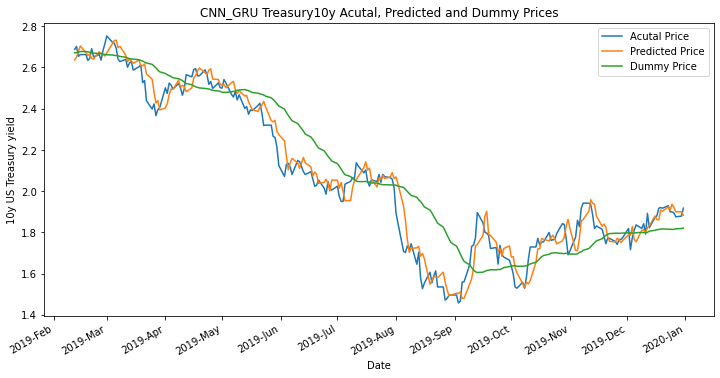

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

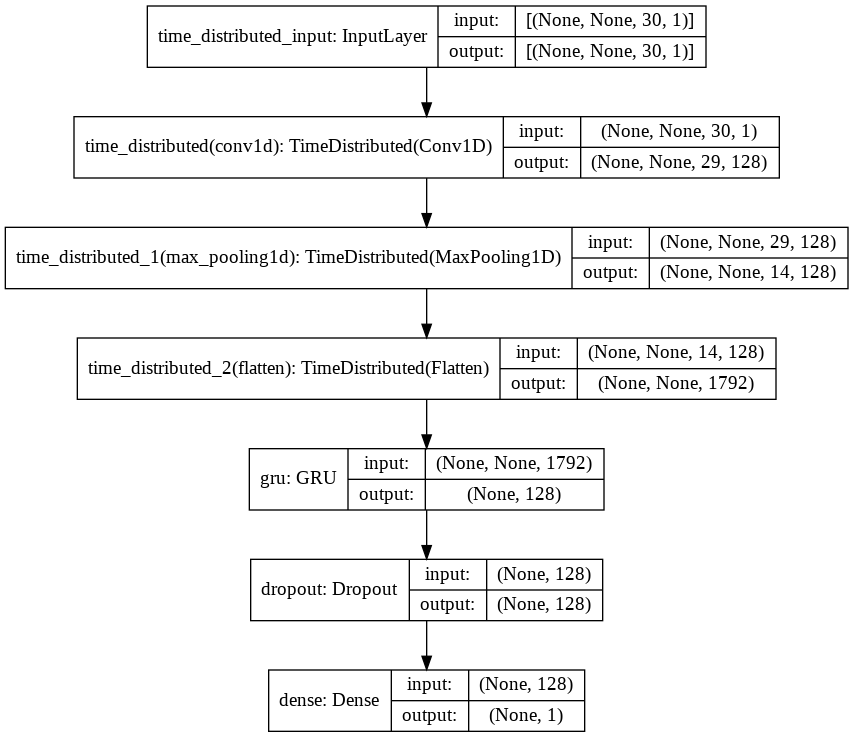

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0022491548738392425
RMSE:  0.047425255653915484
MAE:  0.03569165310876145
Dummy MSE:  0.011907945328582062
Dummy RMSE:  0.10912353242349727
Dummy MAE:  0.08287353397503001


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Treasury10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Treasury10y/assets
